# 08 LGBM Forecast

In [34]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

from typing import List, Tuple
from pandas import DataFrame, Series

import shap
import joblib

import warnings
warnings.filterwarnings("ignore")

In [35]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# widen the column width and overall display width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [36]:
TRAIN_PATH: str = "../data/interim/train.csv"
FORECAST_PATH: str = "../data/interim/forecast.csv"
TARGET_COL: str = "use_house_overall"

In [37]:
train_df: DataFrame = pd.read_csv(TRAIN_PATH, index_col="time", parse_dates=True)
forecast_df: DataFrame = pd.read_csv(FORECAST_PATH, index_col="time", parse_dates=True)

train_df = train_df.select_dtypes(include="number")
forecast_df = forecast_df[train_df.columns]

In [38]:
# --- Hyperparameter tuning with Optuna ---
X_train: DataFrame = train_df[[col for col in train_df.columns if col != TARGET_COL]]
y_train: Series = train_df[TARGET_COL]

def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 32, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
        "seed": 42,
        "verbosity": -1
    }

    tscv = TimeSeriesSplit(n_splits=3)
    mae_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dval = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            param,
            train_set=dtrain,
            valid_sets=[dval],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0) ]
        )

        preds = model.predict(X_val)
        score = mean_absolute_error(y_val, preds)
        mae_scores.append(score)

    return np.mean(mae_scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params: dict = study.best_trial.params
print("Best parameters found by Optuna:", best_params)

[I 2025-06-05 20:38:44,434] A new study created in memory with name: no-name-8a44a23e-7a03-4ea1-81a3-6e668e6c2a6e
[I 2025-06-05 20:38:44,576] Trial 0 finished with value: 0.23669088651787218 and parameters: {'learning_rate': 0.12495207969665825, 'num_leaves': 169, 'feature_fraction': 0.8128601078097702, 'bagging_fraction': 0.6636400724930049, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 0 with value: 0.23669088651787218.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 0.17728
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l1: 0.285184
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 0.243173
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 0.132138
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:44,773] Trial 1 finished with value: 0.2107904914742801 and parameters: {'learning_rate': 0.18716446901548559, 'num_leaves': 202, 'feature_fraction': 0.9976813733792748, 'bagging_fraction': 0.9526600087525146, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 1 with value: 0.2107904914742801.


Early stopping, best iteration is:
[64]	valid_0's l1: 0.272496
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 0.227737
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.321498
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:44,924] Trial 2 finished with value: 0.3027573617595576 and parameters: {'learning_rate': 0.03588899535959021, 'num_leaves': 83, 'feature_fraction': 0.6961689669662716, 'bagging_fraction': 0.9957799114300003, 'bagging_freq': 6, 'min_child_samples': 16}. Best is trial 1 with value: 0.2107904914742801.
[I 2025-06-05 20:38:44,994] Trial 3 finished with value: 0.34598537604360186 and parameters: {'learning_rate': 0.0744103789578396, 'num_leaves': 38, 'feature_fraction': 0.9958336627847642, 'bagging_fraction': 0.8009205844011891, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.2107904914742801.
[I 2025-06-05 20:38:45,060] Trial 4 finished with value: 0.35152804153271555 and parameters: {'learning_rate': 0.18254649664776612, 'num_leaves': 161, 'feature_fraction': 0.9722643523899148, 'bagging_fraction': 0.6148230148554567, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.2107904914742801.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.307059
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.323295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.339923
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores

[I 2025-06-05 20:38:45,130] Trial 5 finished with value: 0.3391445503415624 and parameters: {'learning_rate': 0.13487676105451038, 'num_leaves': 233, 'feature_fraction': 0.8567209480079749, 'bagging_fraction': 0.7475326385200339, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 1 with value: 0.2107904914742801.
[I 2025-06-05 20:38:45,199] Trial 6 finished with value: 0.35013319968358675 and parameters: {'learning_rate': 0.14251113886834085, 'num_leaves': 199, 'feature_fraction': 0.9021688202566548, 'bagging_fraction': 0.70896024284495, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 1 with value: 0.2107904914742801.
[I 2025-06-05 20:38:45,268] Trial 7 finished with value: 0.3403217340054181 and parameters: {'learning_rate': 0.09929407314064095, 'num_leaves': 87, 'feature_fraction': 0.6775339722545773, 'bagging_fraction': 0.6822239808093246, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 1 with value: 0.2107904914742801.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.302772
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's l1: 0.334435
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.306304
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores 

[I 2025-06-05 20:38:45,383] Trial 8 finished with value: 0.3346123082069295 and parameters: {'learning_rate': 0.16035624044431077, 'num_leaves': 212, 'feature_fraction': 0.7104613395900302, 'bagging_fraction': 0.6751724897498909, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 1 with value: 0.2107904914742801.


Did not meet early stopping. Best iteration is:
[93]	valid_0's l1: 0.289175
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's l1: 0.133911
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's l1: 0.2955
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:45,616] Trial 9 finished with value: 0.24163690254116496 and parameters: {'learning_rate': 0.08183666078893129, 'num_leaves': 121, 'feature_fraction': 0.6901440171301082, 'bagging_fraction': 0.8710825389161195, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 1 with value: 0.2107904914742801.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.294652
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 0.10288
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 0.277702
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:45,925] Trial 10 finished with value: 0.20034832201179933 and parameters: {'learning_rate': 0.1953551931447543, 'num_leaves': 254, 'feature_fraction': 0.9284927469328609, 'bagging_fraction': 0.9897429939242043, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 10 with value: 0.20034832201179933.


Early stopping, best iteration is:
[38]	valid_0's l1: 0.220462
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.0991132
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.270723
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:46,236] Trial 11 finished with value: 0.18963675422270312 and parameters: {'learning_rate': 0.19621567482219018, 'num_leaves': 256, 'feature_fraction': 0.923716186282903, 'bagging_fraction': 0.9959920480770494, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[33]	valid_0's l1: 0.199074
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 0.10794
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:46,610] Trial 12 finished with value: 0.20367965470851912 and parameters: {'learning_rate': 0.19890361422821926, 'num_leaves': 254, 'feature_fraction': 0.9089379734689317, 'bagging_fraction': 0.9006468593158964, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.273676
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 0.229423
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.0926708
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.266481
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:46,974] Trial 13 finished with value: 0.20853517261035323 and parameters: {'learning_rate': 0.16747029385522225, 'num_leaves': 252, 'feature_fraction': 0.6002311258335661, 'bagging_fraction': 0.9985107547846174, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[15]	valid_0's l1: 0.266453
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.27923
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 0.296272
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:47,181] Trial 14 finished with value: 0.2656432173636494 and parameters: {'learning_rate': 0.19817086051172864, 'num_leaves': 223, 'feature_fraction': 0.9187779732217234, 'bagging_fraction': 0.9052588017943345, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[80]	valid_0's l1: 0.221427
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 0.116903
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 0.291484
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:47,398] Trial 15 finished with value: 0.22532015742865683 and parameters: {'learning_rate': 0.16647934064106967, 'num_leaves': 176, 'feature_fraction': 0.7868676714846279, 'bagging_fraction': 0.8252053109056721, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[34]	valid_0's l1: 0.267573
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.206397
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.335894
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:47,633] Trial 16 finished with value: 0.2864252797171978 and parameters: {'learning_rate': 0.0216191697414973, 'num_leaves': 135, 'feature_fraction': 0.9436742832500551, 'bagging_fraction': 0.944229681324345, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.316985
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 0.107207
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's l1: 0.283375
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:47,891] Trial 17 finished with value: 0.21113319736379532 and parameters: {'learning_rate': 0.11567318083357656, 'num_leaves': 255, 'feature_fraction': 0.8652141137287448, 'bagging_fraction': 0.8601542701771185, 'bagging_freq': 3, 'min_child_samples': 8}. Best is trial 11 with value: 0.18963675422270312.
[I 2025-06-05 20:38:48,053] Trial 18 finished with value: 0.2643891543751994 and parameters: {'learning_rate': 0.14819468524033474, 'num_leaves': 192, 'feature_fraction': 0.83457734546284, 'bagging_fraction': 0.9499454370389467, 'bagging_freq': 1, 'min_child_samples': 18}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[79]	valid_0's l1: 0.242818
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.298498
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's l1: 0.214955
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:48,295] Trial 19 finished with value: 0.21796846505044887 and parameters: {'learning_rate': 0.17667882109340413, 'num_leaves': 231, 'feature_fraction': 0.7637853404059761, 'bagging_fraction': 0.7527949931956002, 'bagging_freq': 3, 'min_child_samples': 5}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[45]	valid_0's l1: 0.114303
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 0.282122
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l1: 0.257481
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:48,543] Trial 20 finished with value: 0.2465726739812846 and parameters: {'learning_rate': 0.04888067371238827, 'num_leaves': 109, 'feature_fraction': 0.9496867899401724, 'bagging_fraction': 0.9609006949510268, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.148032
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.299851
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.291835


[I 2025-06-05 20:38:48,627] Trial 21 finished with value: 0.32858198176119485 and parameters: {'learning_rate': 0.19995636344647363, 'num_leaves': 250, 'feature_fraction': 0.8915173449177385, 'bagging_fraction': 0.9017238613075199, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 11 with value: 0.18963675422270312.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.434947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.271085
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.103666
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:48,873] Trial 22 finished with value: 0.2043148896833612 and parameters: {'learning_rate': 0.1868181012182539, 'num_leaves': 235, 'feature_fraction': 0.9311855613816463, 'bagging_fraction': 0.9028301768164796, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[24]	valid_0's l1: 0.263151
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.246127
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 0.13195
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:49,110] Trial 23 finished with value: 0.21570564690163085 and parameters: {'learning_rate': 0.15418184845027844, 'num_leaves': 255, 'feature_fraction': 0.8714205483695268, 'bagging_fraction': 0.9804857130664247, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[72]	valid_0's l1: 0.279369
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l1: 0.235798
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.105138
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:49,441] Trial 24 finished with value: 0.2073284222709438 and parameters: {'learning_rate': 0.17996122860162486, 'num_leaves': 223, 'feature_fraction': 0.8983061047041441, 'bagging_fraction': 0.9248602773789791, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.277425
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid_0's l1: 0.239422
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 0.117653
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's l1: 0.289382
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:49,634] Trial 25 finished with value: 0.21734874013683825 and parameters: {'learning_rate': 0.166413247843181, 'num_leaves': 189, 'feature_fraction': 0.9616257266748215, 'bagging_fraction': 0.8556594755921126, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[67]	valid_0's l1: 0.245011
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.1211
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 0.287252
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:49,859] Trial 26 finished with value: 0.21924565828738496 and parameters: {'learning_rate': 0.1933237625745229, 'num_leaves': 217, 'feature_fraction': 0.8266316154876313, 'bagging_fraction': 0.9700580978068631, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 11 with value: 0.18963675422270312.
[I 2025-06-05 20:38:50,037] Trial 27 finished with value: 0.2607917194878268 and parameters: {'learning_rate': 0.17438191713949797, 'num_leaves': 239, 'feature_fraction': 0.9207896908360067, 'bagging_fraction': 0.9150862953025957, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 11 with value: 0.18963675422270312.


Early stopping, best iteration is:
[30]	valid_0's l1: 0.249385
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.283792
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's l1: 0.218868
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0.279715
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:50,182] Trial 28 finished with value: 0.2688493436396087 and parameters: {'learning_rate': 0.13743934669889607, 'num_leaves': 148, 'feature_fraction': 0.8523823957810193, 'bagging_fraction': 0.8784154987284141, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.296055
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.230778
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's l1: 0.118811
Training until validation scores don't improve for 20 rounds


[I 2025-06-05 20:38:50,489] Trial 29 finished with value: 0.2178100906213117 and parameters: {'learning_rate': 0.12650170482487466, 'num_leaves': 176, 'feature_fraction': 0.7851522247466314, 'bagging_fraction': 0.9333429092698013, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 11 with value: 0.18963675422270312.


Did not meet early stopping. Best iteration is:
[83]	valid_0's l1: 0.286933
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid_0's l1: 0.247687
Best parameters found by Optuna: {'learning_rate': 0.19621567482219018, 'num_leaves': 256, 'feature_fraction': 0.923716186282903, 'bagging_fraction': 0.9959920480770494, 'bagging_freq': 1, 'min_child_samples': 5}


In [39]:
def train_lgbm_forecast(
    train_df: DataFrame,
    forecast_df: DataFrame,
    features: List[str],
    target: str
) -> Tuple[DataFrame, lgb.Booster, DataFrame]:
    """
    Train LightGBM on time series data and forecast the next horizon.
    """
    X_train: DataFrame = train_df[features]
    y_train: Series = train_df[target]
    X_test: DataFrame = forecast_df[features]

    dtrain = lgb.Dataset(X_train, label=y_train)

    params: dict = {
        **best_params
    }

    model: lgb.Booster = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=300
    )

    preds: np.ndarray = model.predict(X_test)
    pred_df: DataFrame = pd.DataFrame({target: preds}, index=forecast_df.index)

    return pred_df, model, X_train

In [40]:
# Run forecast on training
feature_cols: List[str] = [col for col in train_df.columns if col != TARGET_COL]
forecast_df_pred, model, X_train = train_lgbm_forecast(train_df, forecast_df, feature_cols, TARGET_COL)

In [41]:
# Evaluate on holdout data
actual: Series = forecast_df[TARGET_COL]
predicted: Series = forecast_df_pred[TARGET_COL]
mae: float = mean_absolute_error(actual, predicted)
print(f"LGBM MAE ({TARGET_COL}): {mae:.4f}")

LGBM MAE (use_house_overall): 0.0616


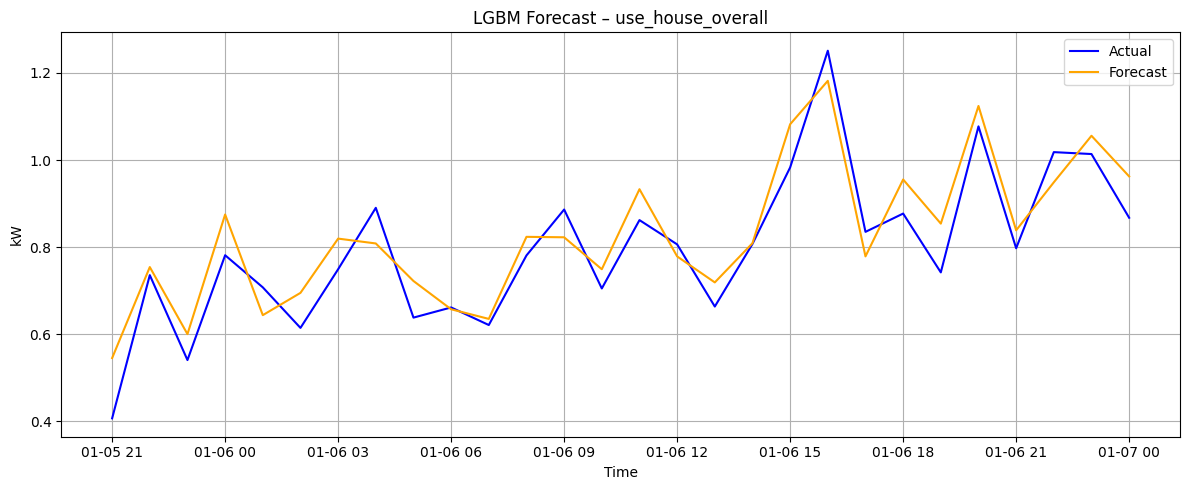

In [42]:
plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual", color="blue")
plt.plot(predicted, label="Forecast", color="orange")
plt.title(f"LGBM Forecast – {TARGET_COL}")
plt.xlabel("Time")
plt.ylabel("kW")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The LightGBM model achieves a strong MAE of 0.0680 kW on hourly energy consumption forecasts, significantly outperforming the VAR baseline. Given the typical consumption range, this translates to a low relative error and offers a solid baseline for short-term prediction. In practical terms, it enables reliable demand forecasting for smart energy management, helping optimize consumption, reduce costs, and support better integration of renewable energy in households.

## Model explainer

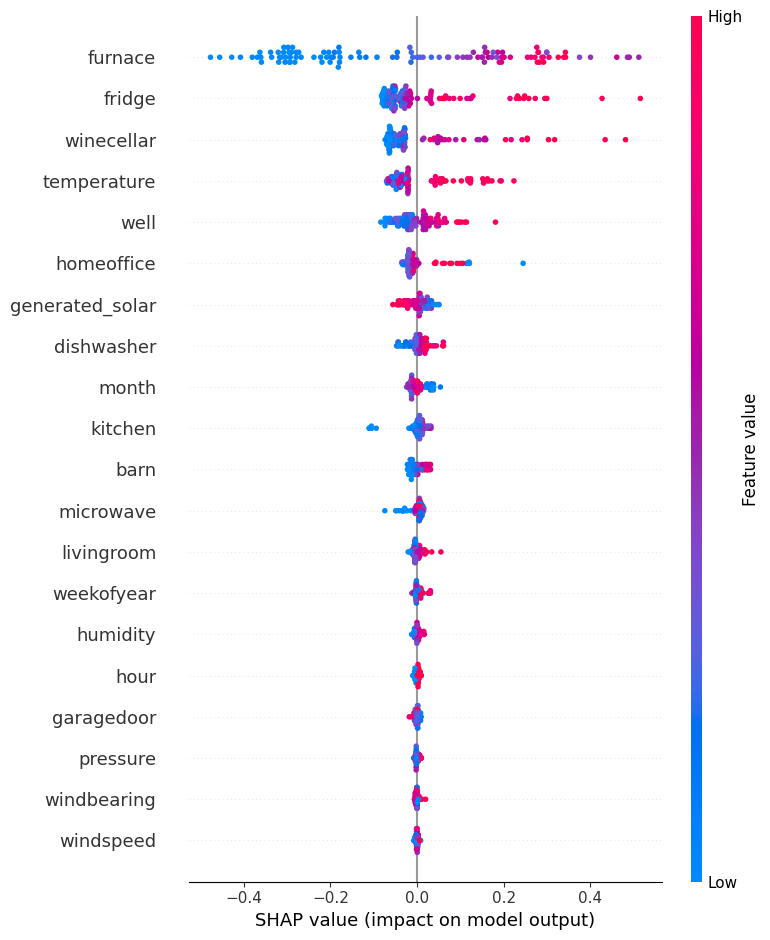

In [43]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False)
plt.tight_layout()
plt.show()

SHAP values were used to interpret the LightGBM model's predictions and understand the impact of each feature on energy consumption. This plot shows that appliances like the furnace, fridge, and wine cellar had the strongest influence, aligning with expected high-consumption devices. We included SHAP to ensure the model's decisions are transparent, interpretable, and aligned with domain knowledge, which is essential when aiming for actionable insights in real-world energy optimization.

### What 0.137 kW MAE *means in context*

* **Typical household usage per hour** ranges between 0.5 to 3.0 kW depending on time of day and appliances.
* A MAE of 0.137 kW is roughly **5–15% relative error**, meaning the model can **reliably capture short-term trends and spikes**.
* That’s accurate enough to **trigger appliance-level suggestions**, align with **solar generation windows**, and make **micro-optimization decisions**.

### Business Use Cases Enabled by This Accuracy

#### 1. **Personalized appliance insights**

* Detect inefficient devices (e.g., fridge runs too often, wine cellar always on) by comparing predicted vs actual usage.
* Alert user when a device behaves abnormally (early detection of faults or standby leakage).

#### 2. **Solar generation alignment**

* Shift flexible appliance use (dishwasher, laundry, EV charging) to periods of predicted solar surplus.
* Recommend "best hour" of the day to run high-load devices based on predicted net consumption.

#### 3. **Dynamic energy pricing optimization**

* For homes with variable electricity pricing: pre-cool, pre-heat, or run appliances in low-tariff periods.
* Suggest optimal times to consume or feed back energy to the grid.

#### 4. **Carbon-aware recommendations**

* Combine usage forecast with grid CO₂ intensity to suggest low-impact usage windows.

#### 5. **Preventive overload control**

* Forecast peaks that may exceed household fuse capacity or solar inverter limits, and delay non-essential loads.

#### 6. **Behavior nudging**

* Generate weekly summaries: “You could’ve saved 0.80 kWh (≈0.25€) by running laundry 2 hours later on Thursday.”
* Show predicted vs actual consumption with actionable tips.

In [44]:
joblib.dump(model, "../models/lgbm_model.pkl")

['../models/lgbm_model.pkl']

In [46]:
joblib.dump(feature_cols, "../models/lgbm_features.pkl")

['../models/lgbm_features.pkl']